# The Lazy Gardener: Selecting an Optimal Watering Strategy through Reinforcement Learning
### MSCA 32020 Reinforcement Learning
#### Spring 2021
#### Team Members:
 - Nina Randorf
 - Remy Zhong
 - Arpit Parihar
#
 ****
### Model 3 - Q-Learning
 ****

### Importing modules

In [1]:

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from TLG_env import garden_env


### Declare environment constants and transition matrices

In [2]:
# Dictionaries to keep track of weather, bunny and actions
WEATHER = {0: "Sunny", 1: "Rainy", 2: "Stormy"}
BUNNY = {0: "No_Bunny", 1: "Bunny"}
ACTIONS = {-1: "Pump", 0: "Rest", 1: "Water"}

# List of possible saturation states
STATES = list(range(-1, 6))

# Weather to weather transition matrix
P_WEATHER = pd.DataFrame({0: [0.75, 0.3, 0.4], 1: [0.2, 0.5, 0.4], 2: [0.05, 0.2, 0.2]})

# Weather to bunny transition matrix
P_BUNNY = pd.DataFrame({0: [0.2, 0.8], 1: [0.6, 0.4], 2: [0.9, 0.1]})

### Creating environment instance for Q-Learning algorithm

In [3]:
env = garden_env(WEATHER, BUNNY, ACTIONS, STATES, P_WEATHER, P_BUNNY, no_term=False)

### Declaring algorithm constants

In [4]:
LEARNING_RATE = 0.2
DISCOUNT = 0.99
EPISODES = 20000
DAYS_TILL_HARVEST = 50
HARVEST_REWARD = 50

epsilon = 0.5
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)


### Algorithm loop

In [5]:
try:
    q_table = joblib.load("Files/Q_Table.pkl")
    print("Q table loaded from disk")
except:
    # Random initialization
    q_table = np.random.uniform(low=-0.5, high=0.5, size=(len(env.P_ind), len(env.A)))

    for episode in range(EPISODES):
        # Reset starting state with each episode
        env.reset_env()
        state = env.state
        for day in range(DAYS_TILL_HARVEST):

            # Explore the environment by picking random action
            if np.random.random() > epsilon:
                action = np.argmax(q_table[env.P_ind.index(state)])
            else:
                action = np.random.randint(0, len(env.A))

            # Get new state and reward from the environment
            env.step(action)
            state_new = env.state

            reward = (
                env.reward
                if day < DAYS_TILL_HARVEST - 1
                else env.reward + HARVEST_REWARD
            )

            # Calculate future Q and current Q from Q table, and new Q from modified Bellman's equation
            max_future_q = np.max(q_table[env.P_ind.index(state_new)])
            current_q = q_table[env.P_ind.index(state), action]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (
                reward + DISCOUNT * max_future_q
            )

            # Update Q table with new Q
            q_table[env.P_ind.index(state), action] = new_q
            state = state_new

            # End episode if terminal saturation states are reached
            if eval(state)[0] in [min(env.S), max(env.S)]:
                break
        # Adjust epsilon
        if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value

    # Save Q-table
    _ = joblib.dump(q_table, "Files/Q_Table.pkl")
    print("Q table saved to disk")

Q table loaded from disk


### Displaying final Q-table and policy

In [6]:
# policy = pd.Series([x for x in q_table.argmax(axis=1) - 1], index=QL_Agent.P_ind)
Q_table_final = pd.DataFrame(q_table, columns=(env.A.values()), index=env.P_ind)

# Obtain policy from Q-table
q_values = pd.Series([x for x in q_table.max(axis=1)], index=env.P_ind)
policy = pd.Series([x for x in q_table.argmax(axis=1)], index=env.P_ind)
Q_table_final["Policy_QLearning"] = pd.Series(
    [env.A[x] for x in q_table.argmax(axis=1) - 1], index=env.P_ind
)
Q_table_final.loc[[eval(x)[0] not in [min(env.S), max(env.S)] for x in env.P_ind], :]


,Pump,Rest,Water,Policy_QLearning
"(0, 0, 0)",-1508.325662,-1345.429346,46.403634,Water
"(1, 0, 0)",-1206.550501,15.988999,36.868120,Water
"(2, 0, 0)",-4.026644,36.807944,-4.216469,Rest
"(3, 0, 0)",-37.029917,36.972250,-56.659771,Rest
"(4, 0, 0)",35.228744,-45.769751,-190.730218,Pump
"(0, 1, 0)",-1039.559958,-425.703279,38.709092,Water
"(1, 1, 0)",-245.791657,14.286139,36.648949,Water
"(2, 1, 0)",23.123579,36.420658,25.814597,Rest
"(3, 1, 0)",37.156630,8.582018,-181.878021,Pump
"(4, 1, 0)",37.172243,-71.904898,-832.838494,Pump


### Policy evaluation

In [7]:
env = garden_env(WEATHER, BUNNY, ACTIONS, STATES, P_WEATHER, P_BUNNY, no_term=True)
episode_tracker = pd.DataFrame(columns=["Pump", "Rest", "Water", "Reward", "Died"])

try:
    episode_tracker = joblib.load("Files/Q_sim_episode_tracker.pkl")
    print("Episode tracker loaded from disk")
except:
    for episode in range(1000):
        env.reset_env()
        state = env.state
        episode_stats = {"Pump": 0, "Rest": 0, "Water": 0, "Reward": 0, "Died": 0}
        for day in range(DAYS_TILL_HARVEST):
            env.step(policy.loc[state])
            future_state = env.state
            episode_stats["Reward"] += (
                env.reward
                if day < DAYS_TILL_HARVEST - 1
                else env.reward + HARVEST_REWARD
            )
            episode_stats[env.A[policy.loc[state] - 1]] += 1
            state = future_state
            if eval(future_state)[0] in [min(env.S), max(env.S)]:
                episode_stats["Died"] += 1
                break
        episode_tracker = episode_tracker.append(episode_stats, ignore_index=True)
    _ = joblib.dump(episode_tracker, "Files/Q_sim_episode_tracker.pkl")
    print("Episode tracker saved to disk")
episode_tracker.mean()

Episode tracker loaded from disk


Pump       3.2200
Rest      21.8320
Water     24.9480
Reward    16.4342
Died       0.0000
dtype: float64

### Visualizations - Value and Policy

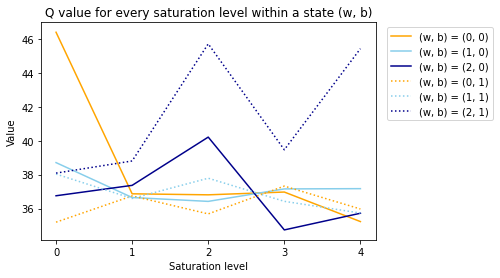

In [8]:
plot_df = pd.DataFrame(
    columns=env.P_bw.index, index=set(env.S) - set([min(env.S), max(env.S)])
)
for i in [(x,) + eval(y) for x in plot_df.index for y in plot_df.columns]:
    plot_df.loc[i[0], f"{i[1:]}"] = q_values.loc[f"{i}"]

col = ["orange", "skyblue", "darkblue"] * 2
linestyle = ["-"] * 3 + ["dotted"] * 3
_ = plt.figure()
for (i, j) in enumerate(plot_df.columns):
    _ = plt.plot(
        plot_df[j], color=col[i], linestyle=linestyle[i], label="(w, b) = " + j
    )

_ = plt.ylabel("Value")
_ = plt.xlabel("Saturation level")
_ = plt.title("Q value for every saturation level within a state (w, b)")
_ = plt.xticks(plot_df.index)
_ = plt.legend(bbox_to_anchor=(1.02, 1))
_ = plt.show()

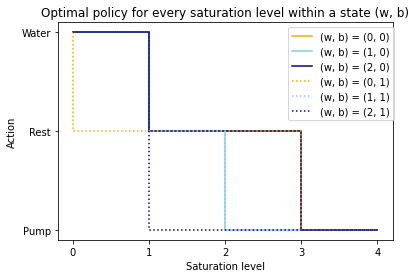

In [9]:
plot_df = pd.DataFrame(
    columns=env.P_bw.index, index=set(env.S) - set([min(env.S), max(env.S)])
)
for i in [(x,) + eval(y) for x in plot_df.index for y in plot_df.columns]:
    plot_df.loc[i[0], f"{i[1:]}"] = policy.loc[f"{i}"]

col = ["orange", "skyblue", "darkblue"] * 2
linestyle = ["-"] * 3 + ["dotted"] * 3
_ = plt.figure()
for (i, j) in enumerate(plot_df.columns):
    _ = plt.plot(
        plot_df[j],
        color=col[i],
        linestyle=(linestyle[i]),
        label="(w, b) = " + j,
        drawstyle="steps",
    )

_ = plt.ylabel("Action")
_ = plt.xlabel("Saturation level")
_ = plt.title("Optimal policy for every saturation level within a state (w, b)")
_ = plt.xticks(plot_df.index)
_ = plt.yticks(sorted(policy.unique()), env.A.values())
_ = plt.legend(bbox_to_anchor=(1.02, 1))
_ = plt.show()
